# Weibull model with covariates

In [2]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az
import pytensor.tensor as pt

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from lifelines import KaplanMeierFitter, WeibullAFTFitter

from lifelines.utils import concordance_index
from sklearn.metrics import root_mean_squared_error

from xarray import open_dataset # To read the trace of an already trained Bayesian model

import warnings
warnings.filterwarnings('ignore')

In [3]:
ALPHA = 0.05 # Significance level
TRAIN = True # Train the Bayesian model? Training it is taking too much time

CONTINUOUS_VARIABLES = [
    "age",
    "size",
    "nodes",
    "prog",
    "oest"
]

CATEGORICAL_VARIABLES = [
    "treat",
    "men",
    "grade"
]

PREDS = [
    "age",
    "size",
    "nodes",
    "prog",
    "oest",
    "treat_1",
    "men_2",
    "grade_2",
    "grade_3"
]

In [4]:
DatOriginal = pd.read_csv('data/Recurrence free survival in breast cancer patients.csv')

## Preprocessing the data

Apply MinMaxScaler into continuous variables

In [5]:
scaler = MinMaxScaler()

DatOriginal[CONTINUOUS_VARIABLES] = scaler.fit_transform(DatOriginal[CONTINUOUS_VARIABLES])

Get dummies for categorical variables

In [6]:
DatOriginal = pd.get_dummies(DatOriginal, columns=CATEGORICAL_VARIABLES, drop_first=True)

## Split the data into training and testing

In [7]:
DatOriginal = DatOriginal.sort_values("status").reset_index(drop=True)

In [8]:
DatTraining = DatOriginal.iloc[:-75] 
DatTesting = DatOriginal.iloc[-75:]

---

In [9]:
# Weibull log-survivor function
def WeibullLogSurvivor(t, alpha, beta):
    return -((t/beta)**alpha)

# Weibull survivor function
def WeibullSurvivor(t, alpha, beta):
    return np.exp(WeibullLogSurvivor(t, alpha, beta))

# Time quantile
def TimeQuantile(p, alpha, beta):
    return beta * (-np.log(1-p))**(1/alpha)

## Fit the Weibull AFT model using Bayesian approach

$$
\begin{align*}
T|\alpha,\beta &\sim \text{Weibull}(\alpha,\beta) \\
\alpha|\mu_\alpha &= \exp\{\mu_\alpha\} \\
\mu_\alpha &\sim \textsf{Normal}(0,1) \\
\beta|\mu_\beta,\vec{\zeta} &= \exp\{\mu_\beta+\vec{\zeta}^T\vec{X}\} \\
\mu_\beta &\sim \textsf{Normal}(0,1) \\
\zeta_j &\sim \textsf{Normal}(0,1)
\end{align*}
$$

In [10]:
XTraining = DatTraining[PREDS]
XTesting = DatTesting[PREDS]

coords = {"preds": PREDS}

y = DatTraining["time"].values
cens = (DatTraining["status"]==0).values

In [11]:
with pm.Model(coords=coords, check_bounds=False) as WeibullAFTBayesian:
    X_data = pm.Data("X_data_obs", XTraining)

    # Regression
    MuBeta = pm.Normal("MuBeta", 0, 1)
    Zeta = pm.Normal("Zeta", 0, 1, dims="preds")

    # Weibull parameters
    MuAlpha = pm.Normal("MuAlpha", 0, 1)
    Alpha = pm.Deterministic("Alpha", np.exp(MuAlpha))
    Beta = pm.Deterministic("Beta", np.exp(MuBeta + pm.math.dot(Zeta, X_data.T)))

    # Time quantile
    #MedianTime = pm.Deterministic("MedianTime", TimeQuantile(0.5, Alpha, Beta))

    # Log-likelihood
    Logdensity = pm.Weibull("TimesObserved", Alpha, Beta[~cens], observed=y[~cens])
    Logsurvivor = pm.Potential("TimesCensored", WeibullLogSurvivor(y[cens], Alpha, Beta[cens]))

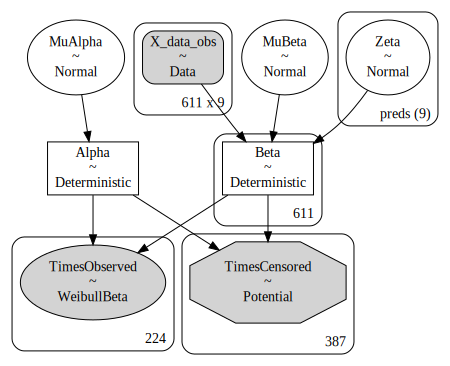

In [12]:
pm.model_to_graphviz(WeibullAFTBayesian)

In [13]:
if TRAIN:
    with WeibullAFTBayesian:
        TraceWeibullAFT = pm.sample(draws=500, tune=500, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [MuBeta, Zeta, MuAlpha]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


Save the trace

In [14]:
if TRAIN:
    TraceWeibullAFT.posterior.to_netcdf("WeibullAFT.h5", engine="scipy")

Load the trace

In [15]:
if not TRAIN:
    TraceWeibullAFT = open_dataset("WeibullAFT.h5", engine="scipy")

Get a statistical summary of the posterior distribution

In [16]:
Summary = az.summary(TraceWeibullAFT, kind="stats", stat_focus="median", hdi_prob=1-ALPHA)
Summary[Summary.index.str.startswith(("MuAlpha", "Alpha", "MuBeta", "Zeta"))]

,median,mad,eti_2.5%,eti_97.5%
MuBeta,7.932,0.160,7.465,8.420
Zeta[age],0.883,0.266,0.105,1.653
Zeta[size],-0.670,0.232,-1.363,0.004
Zeta[nodes],-1.804,0.203,-2.370,-1.207
Zeta[prog],2.211,0.449,0.967,3.653
Zeta[oest],-0.161,0.250,-0.860,0.566
Zeta[treat_1],0.214,0.071,0.014,0.424
Zeta[men_2],-0.348,0.091,-0.626,-0.060
Zeta[grade_2],-0.222,0.118,-0.577,0.106
Zeta[grade_3],-0.408,0.129,-0.793,-0.050


Get punctual estimates for the parameters 

In [17]:
HatAlpha = Summary["median"]["Alpha"]
HatBetas = Summary[Summary.index.str.startswith("Beta")]["median"]

HatMuBeta = Summary["median"]["MuBeta"]
HatZetas = Summary[Summary.index.str.startswith("Zeta")]["median"]

## Plotting the survivor function 

Calculate the survivor function for the training data set, and plot it to get a visual representation of the model

In [18]:
t_vect = np.linspace(0, 3_000)
Survivors = []

for b in HatBetas:
    for t in t_vect:
        if t==t_vect[0]:
            _ = [WeibullSurvivor(t, HatAlpha, b)]
        else:
            _.append(WeibullSurvivor(t, HatAlpha, b))
    Survivors.append(_)

Survivors = np.array(Survivors)

SurvivorRiskAdjusted = Survivors.mean(axis=0)

Plot the survivor function, and compare it with the KM estimate fit with the training data

In [19]:
KM = KaplanMeierFitter()
KM.fit(DatTraining['time'], DatTraining['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 611 total observations, 387 right-censored observations>

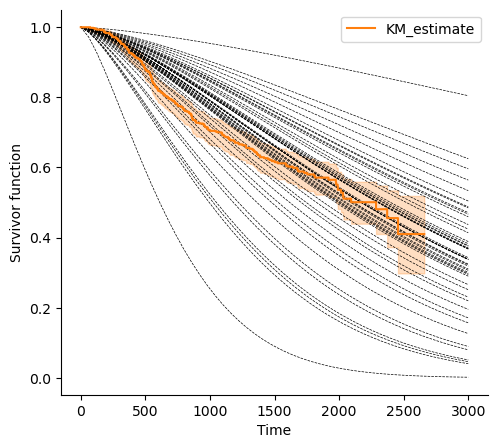

In [20]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

for s in Survivors[:50]:
    ax.plot(
        t_vect,
        s,
        color='k',
        linestyle="--",
        linewidth=0.5
    )

KM.plot_survival_function(color=mpl.colormaps['tab10'].colors[1])

#ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

Calculate the risk-adjusted survivor function, and compare it with the KM estimate fit with the training data

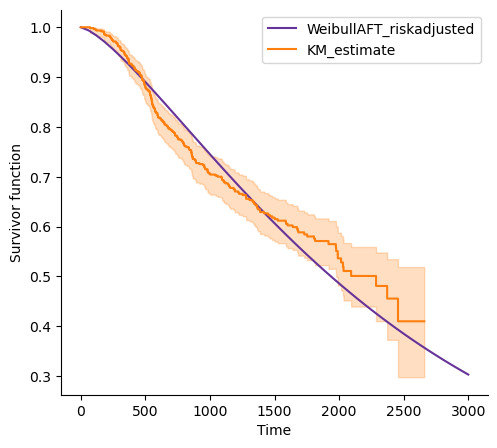

In [21]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    t_vect,
    SurvivorRiskAdjusted,
    color='rebeccapurple',
    label="WeibullAFT_riskadjusted"
)

KM.plot_survival_function(color=mpl.colormaps['tab10'].colors[1])

#ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

## Evaluate the model

Getting the median survival time of the testing observations

In [22]:
HatBetasTesting = np.exp(HatMuBeta + np.dot(DatTesting[PREDS], HatZetas).astype("float"))

for b in HatBetas:
    MedianTimeTesting = TimeQuantile(0.5, HatAlpha, HatBetasTesting)    

Add the median time as the predicted time for the testing data, and calculate the RMSE.

In [23]:
DatTesting["PredictedTime_Bayesian"] = MedianTimeTesting

RmseBayesian = round(root_mean_squared_error(DatTesting["time"], DatTesting["PredictedTime_Bayesian"]), 4)
CIndexBayesian = round(concordance_index(DatTesting["time"], DatTesting["PredictedTime_Bayesian"]), 4)

RmseBayesian, CIndexBayesian

(1191.6275, np.float64(0.611))

In [31]:
DatTesting["PredictedTime_Bayesian"]

611    1451.627817
612    1410.021679
613    2113.793018
614    2434.689041
615    1903.201438
          ...     
681    1769.705599
682    1610.581941
683    1494.087982
684    2189.321363
685    1791.530491
Name: PredictedTime_Bayesian, Length: 75, dtype: float64

## Fit the WeibullAFT model using ``lifelines``

$\lambda$ is what is tipically denoted as $\beta$, i.e. the scale parameter.

$\exp\{\rho[\text{intercept}]\}$ is what is tipically denoted as $\alpha$, i.e. the shape parameter.

In [24]:
WeibAFTModel = WeibullAFTFitter(alpha=ALPHA)

WeibAFTModel.fit(
    DatTraining,
    'time',
    'status',
    formula="+".join(PREDS)
)

<lifelines.WeibullAFTFitter: fitted with 611 total observations, 387 right-censored observations>

In [25]:
WeibAFTModel.print_summary()

<lifelines.WeibullAFTFitter: fitted with 611 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'status'
   number of observations = 611
number of events observed = 224
           log-likelihood = -1977.27
         time fit was run = 2025-04-09 04:59:22 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ Intercept  8.33   4142.96      0.28            7.77            8.89             2370.05             7242.10
        age        0.49      1.63      0.45           -0.40            1.37                0.67                3.95
        size      -0.99      0.37      0.39           -1.76           -0.23                0.17                0.79
        nodes     -1.88      0.15      0.30           -2.48           -1.29                0.08                0.28
        prog       4.02     55.71      1.12            1.83            6.21                6.24              497.26
        oest      -0.44      0.65      0.39           -1.20            0.32                0.30                1.38
        treat_1    0.20      1.22      0.11           -0.01            0.41                0.99                1.50
        men_2     -0.27      0.76      0.15           -0.57            0.02                0.57                1.02
        grade_2   -0.41      0.66      0.20           -0.81           -0.02                0.45                0.98
        grade_3   -0.58      0.56      0.21           -1.00           -0.16                0.37                0.85
rho_    Intercept  0.32      1.38      0.06            0.21            0.44                1.24                1.55

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ Intercept    0.00 29.23 <0.005    621.50
        age          0.00  1.08   0.28      1.83
        size         0.00 -2.55   0.01      6.53
        nodes        0.00 -6.19 <0.005     30.65
        prog         0.00  3.60 <0.005     11.62
        oest         0.00 -1.13   0.26      1.96
        treat_1      0.00  1.90   0.06      4.11
        men_2        0.00 -1.81   0.07      3.82
        grade_2      0.00 -2.08   0.04      4.72
        grade_3      0.00 -2.70   0.01      7.16
rho_    Intercept    0.00  5.68 <0.005     26.18
---
Concordance = 0.70
AIC = 3976.54
log-likelihood ratio test = 92.49 on 9 df
-log2(p) of ll-ratio test = 50.79

In [26]:
Summary[Summary.index.str.startswith(("MuAlpha", "Alpha", "MuBeta", "Zeta"))]

,median,mad,eti_2.5%,eti_97.5%
MuBeta,7.932,0.160,7.465,8.420
Zeta[age],0.883,0.266,0.105,1.653
Zeta[size],-0.670,0.232,-1.363,0.004
Zeta[nodes],-1.804,0.203,-2.370,-1.207
Zeta[prog],2.211,0.449,0.967,3.653
Zeta[oest],-0.161,0.250,-0.860,0.566
Zeta[treat_1],0.214,0.071,0.014,0.424
Zeta[men_2],-0.348,0.091,-0.626,-0.060
Zeta[grade_2],-0.222,0.118,-0.577,0.106
Zeta[grade_3],-0.408,0.129,-0.793,-0.050


Add the median time as the predicted time for the testing data, and calculate the RMSE.

In [27]:
DatTesting["PredictedTime_Lifelines"] = WeibAFTModel.predict_median(DatTesting)

RmseLifelines = round(root_mean_squared_error(DatTesting["time"], DatTesting["PredictedTime_Lifelines"]), 4)
CIndexLifelines = round(concordance_index(DatTesting["time"], DatTesting["PredictedTime_Lifelines"]), 4)

RmseLifelines, CIndexLifelines

(1308.6665, np.float64(0.5926))

In [32]:
DatTesting["PredictedTime_Lifelines"]

611    1567.056323
612    1338.072315
613    2052.077466
614    2327.880797
615    1761.539735
          ...     
681    1752.604452
682    1634.592051
683    1597.151470
684    2014.943134
685    1686.094670
Name: PredictedTime_Lifelines, Length: 75, dtype: float64

Plot the risk adjusted survivor function, and compare it with the KM estimate fit with the training data

In [28]:
SurvivalRiskAdjusted = pd.DataFrame(WeibAFTModel.predict_survival_function(DatTraining).mean(axis=1), columns=["Prob"])

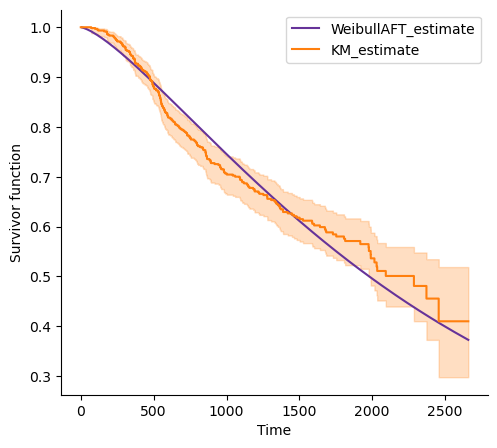

In [29]:
f, ax = plt.subplots(1, 1, figsize=(5.5,5), sharex=True, sharey=True)

ax.plot(
    SurvivalRiskAdjusted.index,
    SurvivalRiskAdjusted["Prob"],
    color='rebeccapurple',
    label="WeibullAFT_estimate"
)

KM.plot_survival_function(color=mpl.colormaps['tab10'].colors[1])

#ax.get_legend().remove()
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel("Survivor function")
#ax.set_title("Weibull proportional hazards")
ax.spines[['right', 'top']].set_visible(False)

### Compare the result from lifelines

In [30]:
print("Here is the result from WeibullAFT Model using Bayesian approach")
print(f"RMSE: {RmseBayesian:.2f}")
print(f"Concordance Index: {CIndexBayesian:.3f}\n")

print("Here is the result from WeibullAFT Model")
print(f"RMSE: {RmseLifelines:.2f}")
print(f"Concordance Index: {CIndexLifelines:.3f}")

Here is the result from WeibullAFT Model using Bayesian approach
RMSE: 1191.63
Concordance Index: 0.611

Here is the result from WeibullAFT Model
RMSE: 1308.67
Concordance Index: 0.593
